# Setup

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

import warnings
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
df_train = pd.read_csv('../input/spaceship-titanic/train.csv', index_col='PassengerId')
df_test = pd.read_csv('../input/spaceship-titanic/test.csv', index_col='PassengerId')

In [3]:
def score_dataset(X, y, model=XGBClassifier()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="accuracy",
    )
    return score

# Data Cleaning

In [4]:
# Merge the splits so we can process them together
df = pd.concat([df_train, df_test])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0001_01 to 9277_01
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12682 non-null  object 
 1   CryoSleep     12660 non-null  object 
 2   Cabin         12671 non-null  object 
 3   Destination   12696 non-null  object 
 4   Age           12700 non-null  float64
 5   VIP           12674 non-null  object 
 6   RoomService   12707 non-null  float64
 7   FoodCourt     12681 non-null  float64
 8   ShoppingMall  12664 non-null  float64
 9   Spa           12686 non-null  float64
 10  VRDeck        12702 non-null  float64
 11  Name          12676 non-null  object 
 12  Transported   8693 non-null   object 
dtypes: float64(6), object(7)
memory usage: 1.4+ MB


## Create Features

In [5]:
df['Cabin']
df['Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0] if type(x) == str else np.nan)
df['Num'] = df['Cabin'].apply(lambda x: x.split('/')[1] if type(x) == str else np.nan)
df['Side'] = df['Cabin'].apply(lambda x: x.split('/')[2] if type(x) == str else np.nan)

## Missing Values

In [6]:
# Select numerical columns
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in df.drop(['Transported'], axis=1) if df[cname].dtype in ['object']]

In [7]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer(strategy = 'median')
imputed_df = pd.DataFrame(my_imputer.fit_transform(df[numerical_cols]))
imputed_df.columns = numerical_cols
imputed_df.index = df.index

cat_imputer = SimpleImputer(strategy = 'most_frequent')
imputed_df_cat = pd.DataFrame(cat_imputer.fit_transform(df[categorical_cols]))
imputed_df_cat.columns = categorical_cols
imputed_df_cat.index = df.index

In [8]:
df = pd.concat([imputed_df, imputed_df_cat, df['Transported']], axis=1)

## Categorization

In [9]:
ordinal_encoder = OrdinalEncoder()
df[categorical_cols] = ordinal_encoder.fit_transform(df[categorical_cols])

In [10]:
df_test = df.loc[df_test.index, :]
df_train = df.loc[df_train.index, :]

In [11]:
df_train['Transported'] = df_train['Transported'].apply(lambda x: 1 if x==True else 0)
df_test = df_test.drop('Transported', axis=1)

# Feature Engineering

## Correlation Matrix

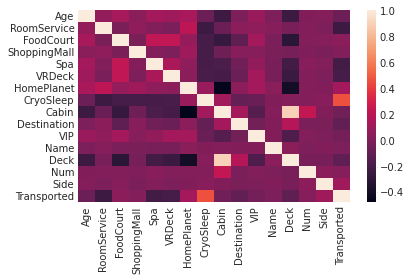

In [12]:
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix)
plt.show()

## Mutual Information

In [13]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [14]:
X = df_train.copy()
y = X.pop("Transported")

mi_scores = make_mi_scores(X, y)
mi_scores

CryoSleep       0.107595
VRDeck          0.073361
Spa             0.071174
RoomService     0.067938
FoodCourt       0.065444
ShoppingMall    0.042219
Name            0.028554
Deck            0.027519
Cabin           0.025983
Num             0.013913
Destination     0.013295
HomePlanet      0.009901
Age             0.004749
VIP             0.000000
Side            0.000000
Name: MI Scores, dtype: float64

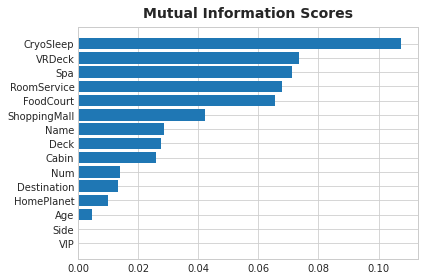

In [15]:
plot_mi_scores(mi_scores)

In [16]:
X = drop_uninformative(X, mi_scores)

In [17]:
score_dataset(X,y)

array([0.74640598, 0.72685451, 0.75100633, 0.76237054, 0.77848101])

In [18]:
X = X.drop('Cabin', axis=1)
score_dataset(X,y)

array([0.74525589, 0.74295572, 0.74123059, 0.78365938, 0.79171461])

# Model and Hyperparameter Tuning

In [19]:
X_train, X_valid, y_train, y_valid= train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [20]:
feature_list = list(X.columns)
X = StandardScaler().fit_transform(X)

## RandomizedSearchCV

In [21]:
clf = RandomForestClassifier(random_state=1)

In [22]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [23]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  13.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  13.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  13.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  13.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  10.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [24]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [25]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=1600,
                       random_state=1)

## Model

In [26]:
rf = RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=1600,
                       random_state=1)

In [27]:
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_train, y_train)
print(rfe.score(X_valid, y_valid))

0.79700977573318


In [28]:
rfe_features = [f for (f, support) in zip(X_train.columns, rfe.support_) if support]
print(rfe_features)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CryoSleep', 'Name', 'Deck', 'Num']


In [29]:
rf.fit(X_train[rfe_features], y_train)
predictions = rf.predict(df_test[rfe_features])

In [30]:
rf.score(X_valid[rfe_features], y_valid)

0.79700977573318

# Create Submission

In [31]:
preds = []
for pred in predictions:
    if pred == 1:
        preds.append(True)
    else:
        preds.append(False)

In [32]:
output = pd.DataFrame({'PassengerId': df_test.index, 'Transported': preds})
output.to_csv('my_submission.csv', index=False)